In [2]:
# This notebook requires py-pde in version 0.17.1 or later
# The package can be obtained from https://github.com/zwicker-group/py-pde
# Alternatively, it can be installed via pip or conda

import pde

# functools and _make_derivative2 are required for anisotropic laplacians
import functools
from pde.grids.operators.cartesian import _make_derivative2

# plotting functions
import matplotlib.pyplot as plt
import numpy as np

# fitting methods
import scipy

# a simple tracker to check parameter sweeps
import datetime
def ETA(step, maxStep, startTime):
    _ETA = None
    total_dt = 0
    dt = 0
    if step==0:
        _ETA = "Indeterminate"
    else:
        dt = datetime.datetime.now() - startTime
        dt = dt.seconds
        total_dt = dt/step * maxStep
        _ETA = (startTime + datetime.timedelta(seconds = total_dt))
        _ETA = str(_ETA.time())
        
    print(f"{int(100 * step / maxStep):>3} % completed. ETA: {_ETA} ({int(total_dt - dt)} seconds remain)." + '\t' * 5,
          end='\r')

# Reaction-Diffusion processes
Generic design features shared by the diverse biochemical interaction networks underlying protein pattern formation in cells include:
 - The dynamics (approximately) conserves the mass of each individual protein species: on the time scale of pattern formation neither protein production nor protein degradation are significant processes.
 - The biochemical reactions are characterised by (positive and negative) feedback mechanisms such that the chemical rate equations describing the dynamics of these reactions are generically nonlinear.
 - The proteins are typically transported by diffusive fluxes.
 
Then, the spatiotemporal dynamics of protein patterns is described by _mass-conserving reaction-diffusion_ (MCRD) equations.

The aspect of mass conservation a constraint imposed by nature: in general, proteins do not appear out of nowhere, nor do they disappear into the void. For biological systems, the mass conservation plays a crucial role that will bother us later in the tutorial; for now, we will focus only on generic properties of pattern-forming reaction-diffusion systems. In the following, you will learn how to set up generic pattern-forming systems with a PDE solver, what individual parts of the differential equations mean, and how to interpret the results.

## The Fitzhugh-Nagumo model
We will analyse and implement a very generic system that shows stationary patterns here, namely the Fitzhugh-Nagumo model. This model was originally proposed as a simplified description of neuron spiking. The model features two components, $u(x,y,t)$ and $v(x,y,t)$, that interact nonlinearly with each other. The general formulation reads:
$$
\partial_t u(x,y,t) = D_u \, \nabla^2 u + f(u) - \sigma \cdot v \, , \\
\partial_t v(x,y,t) = D_v \, \nabla^2 v + u - v \, ,
$$
with $f(u)$ containing all the nonlinear interactions (see below).
For simplicity, the spatial/temporal variables $x$, $y$, and $t$ where omitted on the r.h.s. of the equations.
Note that these equations are a simplified version of the variants typically found in the literature, in particular regarding additional prefactors.

The nonlinear interaction term is the key component that leads to the formation of patterns in this model. Here, we will use
$$f(u) = - u^3 + \alpha \cdot u - \kappa \, .$$
In this representation, all parameters ($D_u$, $D_v$, $\alpha$, $\kappa$, and $\sigma$) are positive.

## Part 1: Analysing the problem analytically

### Problem 1: Understanding the differential equations
For each of the terms on the r.h.s. of the PDEs, state their effect on the dynamics of the system.
For each of the parameters, state how varying this parameter will qualitatively change the dynamics of the system.

_Hint: You should remain on a very broad level here, using phrases such as 'smoothens out rough profiles', 'leads to an increase/decrease of $v$ (or $u$)', etc._

_Hint: For examining the parameters, it helps to consider a specific state of the system. For example, if $u>0$ then the term $\alpha \cdot u$ will lead to further increase of $u$, but it will lead to a decrease if $u<0$._

## Part 2: Testing the system numerically
Different to the source-degradation, we don't know yet what to expect from the system. In particular, the size of the system and the grid resolution need to be determined without knowing the system dynamics. 

### Problem 2: Determining the numerical constraints
Use arbitrarily chosen values for the diffusion constants (e.g., $D_u = 0.1 \; [\mu m^2/s]$ and $D_v = 1.0 \; [\mu m^2/s]$) and the reaction coefficients ($\alpha = 1 \; [1/s]$, $\kappa = 0.1 \; [1/ (s \cdot \mu m ^2)]$, and $\sigma = 1 \; [1/s]$) to make an educated guess about the system size and spatial resolution.

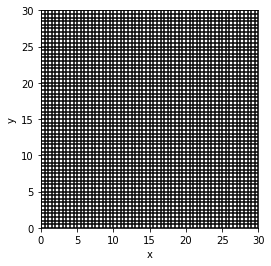

In [3]:
# Define the geometry of the system.
# This time, we use a square grid of width L. The mesh size can be adapted by changing `resolution`.
# Setting `resolution = 10`, for example, means that grid cells are 1/resolution = 0.1 (length units) in size.

L =  ## BLANK ##
resolution =  ## BLANK ##

# pde.CartesianGrid() creates a grid object.
# To avoid boundary effects, we use periodic boundary conditions here.

grid = pde.CartesianGrid(
    [[0, L], [0, L]],
    [int(resolution*L), int(resolution*L)],
    periodic = True
)
grid.plot();

In [4]:
# Since we do not have any membrane dynamics, we do not need a special diffusion operator needed this time.

### Problem 3: Setting up the equations
According to your choice of the system size and resolution, it is now time to define the system parameters. Translate the equations of the Fitzhugh-Nagumo model into the required syntax of `py-pde`. As a reminder, the expression for $v$ is already given.

In [55]:
D_u = 0.1
D_v = 1.0

alpha = 1.0
kappa = 0.1
sigma = 1.0

expr = {'u' : ## BLANK ##, 
        'v' : f'laplace(v) * {D_v} + u - v'}


Now you are almost ready to execute the simulation: only the initial conditions are still missing. In general, for pattern-forming systems, it is a good start to use an unstable fixed point with a sufficiently strong perturbation as initial states. In the Fitzhugh-Nagumo model, for $\kappa = 0$, one fixed point is at $u^* = v^* = 0$, and this fixed point is unstable _in a spatially extended system_ (in a 0D system, this need not be the case). Since we have a comparably small $\kappa$, the actual fixed point will be close to this, so for simplicity, we perturb the system around $(u, v) = (0,0)$.

`random_uniform(grid)` returns an array with values randomly chosen between 0 and 1. The code below transforms this to random values between -1 and 1, centered around the fixed point.

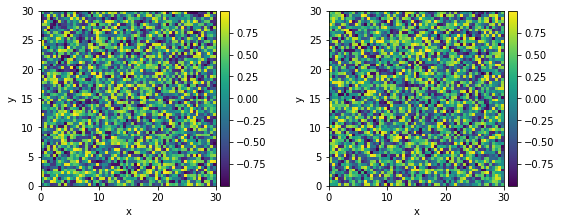

100%|████████████████████████████████████████████████████████████████████████████| 200.0/200.0 [00:11<00:00, 17.70it/s]


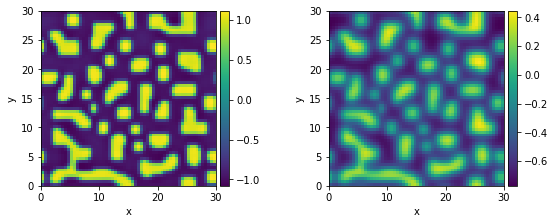

In [56]:
# Construct the field objects
u = pde.ScalarField.random_uniform(grid) * 2. - 1.
v = pde.ScalarField.random_uniform(grid) * 2. - 1.


# Create the PDE object
eq = pde.PDE(expr)

# Set the initial values for all fields, and show it
field = pde.FieldCollection([u,v])
field.plot();

# Simulate the system and show the result
storage = pde.MemoryStorage()

res = eq.solve(field, t_range=200, tracker=[storage.tracker(1), "progress"])
res.plot();

## Part 3: Evaluation
### Problem 4: Interpreting the results
Look at the final state of the simulation. Do you observe a pattern? Do your results match the expactations? What is the order of magnitude of the pattern's characteristic length scale? Run the simulation again with different values for $\kappa$ and note down your observations.

### Problem 5: Quantifying the results
We now want to quantify the characteristic length scale. To do so, we will try to find the center of each spot in the pattern, and calculate the distances to the other spots. This analysis is done by the code below, which shows you a histogram of the spot distances, and returns a proxy for the mean distance between neighboring spots.

The function `get_length_scale` does not contain any blanks, however you are encouraged to walk through it and to understand the underlying idea. This will help you to properly interpret the results later on.

In [9]:
def get_length_scale(data: np.array, nr_of_considered_neighbours: int = 2,
                     show_histogram: bool = True, show_centers: bool = False):
    # Make an empty array of the same size as the data array.
    # This is not necessary, but it helps to visualize things if needed, and is useful for debugging
    pattern_maxima = np.zeros_like(data)
    
    # Make a list to store all pattern spot maxima
    maxima_coordinates = []
    
    # Define some auxiliary quantities
    lx, ly = data.shape
    delta = 2 # size of the scanning window to find the maxima
    offsets = [(dx, dy) for dx in range(-delta, delta+1) for dy in range(-delta, delta+1)]
    offsets.remove((0,0)) # coordinate offsets that should be checked
    
    # Scan the entire array and check whether a pixel has the highes value of all neighbours
    for iy, ix in np.ndindex(data.shape):
        nbs = [data[(ix+dx)%lx, (iy+dy)%ly] for dx,dy in offsets]
        if data[ix,iy] > max(nbs):
            pattern_maxima[ix,iy] += 1.
            maxima_coordinates.append(np.array((ix,iy)))
            pattern_maxima[ix, iy] = 1.
            
    # Show the spot centers
    if show_centers:
        plt.imshow(data)
        plt.show();

        plt.imshow(pattern_maxima)
        plt.show();
            
    # List of distances between maxima, default value for all distances if very large (=L*resolution)
    distances = np.full((len(maxima_coordinates), len(maxima_coordinates)), L * resolution * 1.)
    for i in range(len(maxima_coordinates)):
        pt1 = maxima_coordinates[i]
        for j in range(i + 1, len(maxima_coordinates)):
            pt2 = maxima_coordinates[j]
            # add a random number to avoid discretization artifacts later on
            distances[i,j] = distances[j, i] = np.linalg.norm((pt1-pt2) % (L * resolution)) / resolution +\
                                                np.random.rand() * 0.0001
    
    # Take the N smallest distances between all spots:
    N = nr_of_considered_neighbours
    neighbour_distances = [d for lst in distances for d in np.sort(lst)[:N]]
    neighbour_distances.sort()
    
    # Remove duplicates to avoid double-counting.
    # NOTE: this removes too many distances if two distinct pairs of spots have the same distance.
    # By introducing the random number few lines above, this can be avoided
    neighbour_distances = np.unique(neighbour_distances)
    
    # Show a histogram
    if show_histogram:
        _ = plt.hist(neighbour_distances, bins=40)  # arguments are passed to np.histogram
        plt.title(f"Spot distance histogram for {N} closest neighbours.\n" + 
                  f"Minimal distance: {neighbour_distances[0]: .3}; Mean distances: {np.mean(neighbour_distances): .5}")
        plt.show()
    
    
    return np.mean(neighbour_distances)

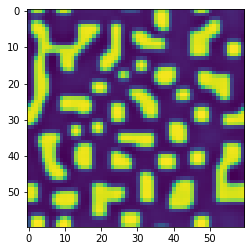

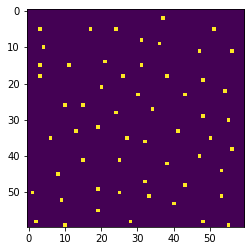

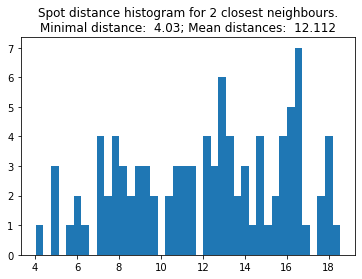

12.112393190883656

In [57]:
get_length_scale(storage.data[-1][0], nr_of_considered_neighbours = 2, show_centers = True)

### Problem 6: Sweeping
Again, we want to check what happens when we change one of the parameters. Here, we want to vary the diffusion constants. Sweep over an appropriate parameter regime and describe how the characteristic pattern length scale $\ell$ changes.

What (approximate) functional dependence of the length scale on the diffusion constant can you derive from your sweep? Is it meaningful to extrapolate your data? Where do you expect your results to fail?

In [11]:
# Define a function that yields the characteristic length scale for a given parameter set
def simulate_and_get_length_scale(D_u = 0.1, D_v = 1.0, alpha = 1.0, kappa = 0.1, sigma = 1.0, tracker = "progress"):
    expr = {'u' : f'laplace(u) * {D_u} + {alpha} * u - u * u * u - {kappa} - {sigma} * v', 
            'v' : f'laplace(v) * {D_v} + u - v'}  
    
    # Construct the field objects
    u = pde.ScalarField.random_uniform(grid) * 2. - 1.
    v = pde.ScalarField.random_uniform(grid) * 2. - 1.

    eq = pde.PDE(expr)
    field = pde.FieldCollection([u,v])

    res = eq.solve(field, t_range=200, tracker=tracker)
    
    return get_length_scale(res.data[0], show_histogram = False)    

In [12]:
# Make a parameter sweep
# Empty list to store the results in
sweep_results = []

# Parameters to sweep over
sweep_parameters = np.power(10, np.arange(-.5, .5, ## BLANK ##))

# Nr of iterations per parameter to get a statistical average
sample_size = ## BLANK ##

# Launch the sweep
start_time = datetime.datetime.now()
for _ in sweep_parameters:
    tmp = []
    for __ in range(sample_size):
        ETA(list(sweep_parameters).index(_) * sample_size + __, len(sweep_parameters) * sample_size, start_time)
        tmp.append(simulate_and_get_length_scale(D_u = 0.1 * _, D_v = 1.0 * _, tracker = []))
    length_scale = np.mean(tmp)
    sweep_results.append(length_scale)

# Convert the results to a numpy array for better handling afterwards
sweep_results = np.array(sweep_results)

# Plot the data
plt.plot(## BLANK ##, ## BLANK ##, 'o', label='data')
plt.title('Characteristic length scale vs. diffusion constant')
plt.xlabel('$D/D_0$')
plt.ylabel('Characteristic length $\ell$')
plt.legend(loc="upper left")
plt.show()

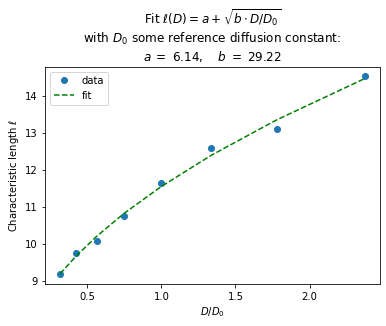

In [35]:
# Guessed function for the length scale depending on the sweep parameter
def fit_func(x, a, b):
    return ## BLANK ##

# Fit parameters and covariance for the fit data
popt, pcov = scipy.optimize.curve_fit(fit_func, sweep_parameters, sweep_results)

# Visualization

plt.plot(sweep_parameters, sweep_results, 'o', label='data')
plt.plot(sweep_parameters, fit_func(sweep_parameters, *popt), 'g--',
         label='fit')
plt.title('Fit $\ell(D) = a + \sqrt{b \cdot D/D_0}$\nwith $D_0$ some reference diffusion constant:\n'+
         f'$a\;=${popt[0]: .3},\t$b\;=${popt[1]: .4}')
plt.xlabel('$D/D_0$')
plt.ylabel('Characteristic length $\ell$')
plt.legend(loc="upper left")
plt.show()

### Problem 7: (Non-)Linearities
The PDEs of the Fitzhugh-Nagumo model include a nonlinear term, namely $-u^3$. This nonlinearity is essential for the formation of patterns here. Test this explicitly by implementing a variant of the Fitzhugh-Nagumo model where the nonlinear term is replaced by $-u^3 \rightarrow -u^n$, with $n$ an integer exponent. In particular, test the cases $n \in \{1, 3, 5\}$, and describe your results. Give an explanation why you observe patterns in some cases, and why not in others.

**Comment from Tom: `py-pde` throws an error that I do not understand for `n=2`. This error is not due to the syntax, as far as I see, and also appears if one writes `- u * u` explicitly in the equations. It seems to be because the system diverges (can be suppressed by adding higher order nonlinear terms), but the error message does not convey this information.**

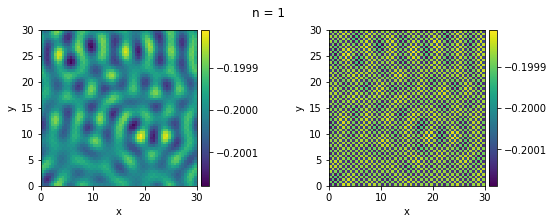

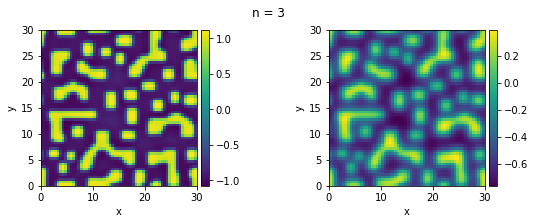

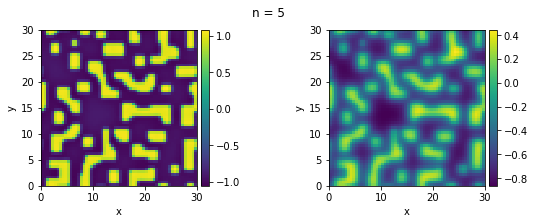

In [101]:
for n in [1, 3, 5]:

    D_u = 0.1 
    D_v = 1.0 

    alpha = 1.0
    kappa = 0.1
    sigma = 1.0 

    expr = {'u' : ## BLANK ##,
            'v' : ## BLANK ##}


    # Construct the field objects
    u = pde.ScalarField.random_uniform(grid) * 2. - 1.
    v = pde.ScalarField.random_uniform(grid) * 2. - 1.


    # Create the PDE object
    eq = pde.PDE(expr)

    # Set the initial values for all fields, and show it
    field = pde.FieldCollection([u,v])

    res = eq.solve(field, t_range=200, tracker=[])
    res.plot(title=f"n = {n}");

## Part 4: A variation of the system (Optional)
### Problem 8: Dynamic patterns
The pattern you analysed above is a stationary pattern, i.e. it will remain the same if you continue simulating for much longer times. For a different parameter regime, the Fitzhugh-Nagumo model shows dynamic patterns that reflect the 'neuron spiking' idea of the model. While these dynamic patterns are particularly difficult to analyse, they are at the same time very nice to look at. The code below simulates such a dynamic pattern. Run and enjoy!

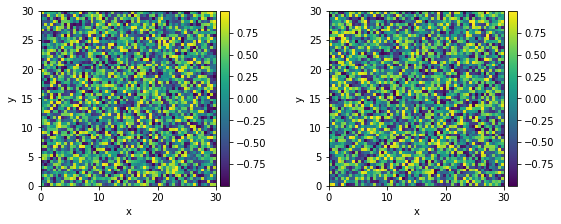

100%|████████████████████████████████████████████████████████████████████████████| 100.0/100.0 [00:08<00:00, 11.46it/s]


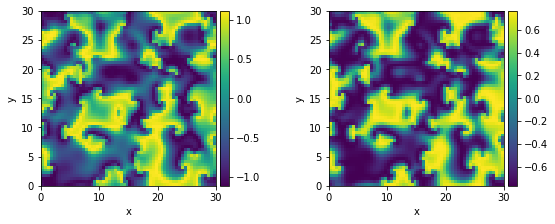

In [91]:
D_u = 0.01
D_v = 0.01

alpha = 2.0
kappa = 0.0
sigma = 2.0

expr = {'u' : f'laplace(u) * {D_u} + {alpha} * u - u * u * u - {kappa} - {sigma} * v',
        'v' : f'laplace(v) * {D_v} + u - v'}

# Construct the field objects
u = pde.ScalarField.random_uniform(grid) * 2. - 1.
v = pde.ScalarField.random_uniform(grid) * 2. - 1.


# Create the PDE object
eq = pde.PDE(expr)

# Set the initial values for all fields, and show it
field = pde.FieldCollection([u,v])
field.plot();

# Simulate the system for 100 time steps, and show the result
storage = pde.MemoryStorage()

res = eq.solve(field, t_range=100, dt = 0.01, tracker=[storage.tracker(0.2), "progress"])
res.plot();


In [ ]:
### Missing: animation of the results ###